#### Objective : This code make use of complaint data against financial companies to perform following tasks on the data
    1. Create Topic models to classify comlplaints in various categories.
    2. We will do test preprcessingw here which remove all token which belong to org and other preprocessing
    3. We will try out two Topic Modelling Algorithms
        1. Latent Dirichtlet ALogorithm - In my exp does not work well on short text data
        2. Non Negative Matrix factorisation

#### About the Dataset
The dataset comprises of Consumer Complaints on Financial products and we’ll see how to classify consumer complaints text into these categories: Debt collection, Consumer Loan, Mortgage, Credit card, Credit reporting, Student loan, Bank account or service, Payday loan, Money transfers, Other financial service, Prepaid card.
Also we will try to identify the companies from the dataset

#### Import the required package

In [140]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import nltk
import spacy
import seaborn as sns
import pickle
from nltk.stem import PorterStemmer
import string

### Read the complaints data csv

In [141]:
complaint_data = pd.read_csv("Consumer_Complaints.csv")

C:\Users\ash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [142]:
### Convert the columns names so that they don't have space and are more readable
complaint_data.columns = [i.lower().replace(" ","_").replace("-","_") for i in complaint_data.columns]
complaint_data.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'tags', 'consumer_consent_provided?',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response?', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

### Lets understand the shape an dtypes of the data

In [143]:
print ("The shape of data is ",complaint_data.shape)
print ("The data types for our data are as follows ")


The shape of data is  (670598, 18)
The data types for our data are as follows 


In [144]:
### All the varables are text - which may correspond to categories and other variables
print (" The number of unique values in each column is as follows")
### Lets do a describe with including objects
complaint_data.describe(include = 'object').T.reset_index()


 The number of unique values in each column is as follows


,index,count,unique,top,freq
0,date_received,670598,1818,08/27/2015,963
1,product,670598,12,Mortgage,210324
2,sub_product,472396,47,Other mortgage,81715
3,issue,670598,95,"Loan modification,collection,foreclosure",106455
4,sub_issue,269868,68,Account status,32633
5,consumer_complaint_narrative,114704,112690,I am filing this complaint because Experian ha...,102
6,company_public_response,145197,10,Company has responded to the consumer and the ...,57364
7,company,670598,3933,Bank of America,61720
8,state,665293,62,CA,97640
9,zip_code,665274,27889,300XX,2147


######  From above description we see that only 114704 rows have complaint text and as we are interested in only those row which have complaint text. We wll drop all rows where complaint narrative is na

In [145]:
#### Keep only the consumer complaints is not null
complaint_data = complaint_data[~complaint_data['consumer_complaint_narrative'].isna()]

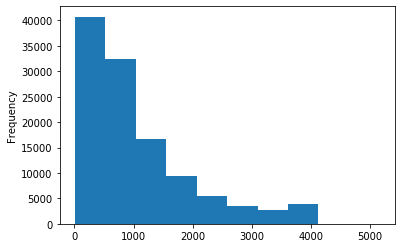

In [146]:
#### Create a distirbution of length of customers complaints. We have very left skew in length of complaints
### Which is expected as most compalints can be written in less than 500 words
complaint_data['consumer_complaint_narrative'].apply(len).plot(kind = 'hist')

In [147]:
### Keep the length columns as a new column
complaint_data['comp_length'] = complaint_data['consumer_complaint_narrative'].apply(len)
complaint_data.reset_index(inplace = True)
complaint_data['consumer_complaint_narrative'] = complaint_data['consumer_complaint_narrative'].str.replace(r"XX+\s","")
complaint_data['consumer_complaint_narrative'] = complaint_data['consumer_complaint_narrative'].str.replace("XXXX","")

In [148]:
complaint_data = complaint_data.sample(frac = 0.5,random_state = 5)
complaint_data.reset_index(inplace = True)

### We will first craete the data processing pipeline to do cleaning on the data

In [149]:
nlp = spacy.load('en_core_web_sm')
### Remove the stop words using spacy predefined list 
stop_words = nlp.Defaults.stop_words
#### Create a list of puntuation to be removed
symbols = " ".join(string.punctuation).split(" ") 
### As we are doing topic modelling itsa good idea to do lemmatisation - as it uses morphologial analysis
ps = PorterStemmer()
import re
#### Lets define the cleaning function and see how it works
def cleanup_text(docs,logging = False):
    texts = []
    counter = 1
    for doc in docs:
        
        if counter % 5000 == 0 :
            print ("Processed %d of out of %d documents"% (counter,len(docs)))
        counter += 1
        
        doc = nlp(doc) ### We are disabling parser as will nt be using it
        
        
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != "-PRON-"]
        
        tokens =[tok for tok in tokens if tok not in symbols]
        tokens = [tok for tok in tokens if tok not in stop_words]
        tokens = [re.sub('[0-9]', '', i) for i in tokens]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return (pd.Series(texts))

In [ ]:
complaint_data['comp_preprocessed'] = cleanup_text(complaint_data['consumer_complaint_narrative'])

In [ ]:
print ("Shape of data before removing NA's ,",complaint_data.shape)
complaint_data =complaint_data[~complaint_data['comp_preprocessed'].isna()]
print ("Shape of data before removing NA's ,",complaint_data.shape)

In [ ]:
complaint_data[['comp_preprocessed','consumer_complaint_narrative']]

### Lets tranform the data using TFIDF vectoriser
1. For learning purpose i am using only tf-idf , but inpractical it as advised to trial out count vectoriser also
2. Also, all paarmeters in TF IDF can be treated as Hyperparameters

In [ ]:
### Lets Create the piprle line for NMF models 
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF 
#####  Let extract from act the features from the dataset

print ("Extracting the tf-idf features form NMF")
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 5, max_features = 500, ngram_range = (1,4))

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(complaint_data['comp_preprocessed'])
print ("done in %0.3fs." % (time() - t0))

In [ ]:
#### Now we will fit model for 10 diff values of clusters
n_comp = [10,20,30,40,50,60,70,80,90,100,110]
loss = []
for comps in n_comp:
  
    t0 = time()
    nmf = NMF(n_components = comps, random_state = 1, beta_loss = 'kullback-leibler',solver = 'mu',max_iter = 200,
             alpha = 0.1, l1_ratio = 0.5).fit(tfidf)
    loss.append(nmf.reconstruction_err_)
    print ("done in %0.3f " % (time() -t0))

In [ ]:
### Let try to create a elbow and find out the best model clusters
plt.plot(loss)
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error - Frobenius Norm')

### Define a function which goes through - topic * word matrix and extract the top keywords

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), 10)

In [136]:
from sklearn.decomposition import LatentDirichletAllocation

In [138]:
# Fit the NMF model
#### Now we will fit model for 10 diff values of clusters
n_comp = [10,20,30,40,50,60,70,80,90,100,110]

for comps in n_comp:
    loss1 = []
    t0 = time()
    lda = LatentDirichletAllocation(n_components=comps, max_iter=2,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
    lda.fit(tfidf)
    print("done in %0.3fs." % (time() - t0))

done in 0.808s.
done in 0.431s.
done in 0.526s.
done in 0.595s.
done in 0.655s.
done in 0.703s.
done in 0.652s.
done in 0.664s.
done in 0.824s.
done in 0.691s.
done in 0.967s.


In [139]:
print_top_words(lda, tfidf_vectorizer.get_feature_names(), 10)

Topic #0: date check return bankruptcy servicing day mortgage xxxx xxxx credit request
Topic #1: debt number value mortgage taxis payment reach receive attach practice
Topic #2: number phone verify company dispute right bill experian phone number know
Topic #3: late payment appear information later office money business credit report student history
Topic #4: want xx xxxx belong monthly payment party student loan approve receive rep immediately
Topic #5: american company fraud monthly new deny balance transfer bill xxxx xxxx xxxx xxxx request
Topic #6: bankruptcy resolve mortgage ve bank wife explanation statement house fcra
Topic #7: overdraft fact acct identity theft address information credit clear fix ignore debit
Topic #8: bring consumer pay claim fraud wife policy limit application overdraft
Topic #9: payment car year date credit thing report plan work past
Topic #10: home monthly payment law people previously month statement like customer legal
Topic #11: discover citibank victi